## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from collections import Counter

## Code

In [2]:
fp_train = "../tdt05-2021-challenge-2/challenge2_train.csv"
fp_test = "../tdt05-2021-challenge-2/challenge2_test.csv"

In [4]:
df_train = pd.read_csv(fp_train)  # 81.488% False, 18.512% True
df_test = pd.read_csv(fp_test)

cleaned_df = df_train.copy(deep=True)

In [5]:
cleaned_df['f2'] = df_train['f2'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)

In [6]:
cleaned_df['f5'] = df_train['f5'].apply(lambda x: None if x == -1 else x)
cleaned_df['f6'] = df_train['f6'].apply(lambda x: None if x == -1 else x)

### Alphabetical transformations

In [7]:
# F10 sin correlasjonsmatrise med løsningen indikerer at bokstaver har nær relasjon til de i nærheten alfabetisk.
# også i f13. Usikker om disse trenger å normaliseres.

f10 = df_train['f10'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
cleaned_df['f10'] = (f10 - f10.min())/(f10.max() - f10.min())

f13 = df_train['f13'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)
cleaned_df['f13'] = (f13 - f13.min())/(f13.max() - f13.min())

# binary
cleaned_df['f20'] = df_train['f20'].apply(lambda x: (x//10)*2 + x%10 if pd.notnull(x) else x)
# f27 is the same as f20, droppit
cleaned_df.drop(['f27'], axis=1, inplace=True)

cleaned_df['f4'] = df_train['f4'].apply(lambda x: (x=='B')*1. if pd.notnull(x) else x)
cleaned_df['f25'] = df_train['f25'].apply(lambda x: (x=='T')*1. if pd.notnull(x) else x)
cleaned_df['f26'] = df_train['f26'].apply(lambda x: (x=='S')*1. if pd.notnull(x) else x)

cleaned_df['f22'] = df_train['f22'].replace({'R': 0, 'G': 1, 'B': 2})


cleaned_df['f18'] = df_train['f18'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
cleaned_df['f19'] = df_train['f19'].apply(lambda x: 10*x if pd.notnull(x) else x)


### HEX transforms

In [8]:
# F8
f8 = df_train['f8'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f8'] = (f8 - f8.min())/(f8.max() - f8.min())  # NORMALIZING

# F12
f12 = df_train['f12'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f12'] = (f12 - f12.min())/(f12.max() - f12.min())  # NORMALIZING

# F14
f14 = df_train['f14'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f14'] = (f14 - f14.min())/(f14.max() - f14.min())  # NORMALIZING

# F15
f15 = df_train['f15'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f15'] = (f15 - f15.min())/(f15.max() - f15.min())  # NORMALIZING

# F23
f23 = df_train['f23'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f23'] = (f23 - f23.min())/(f23.max() - f23.min())  # NORMALIZING

In [9]:
# f1: Not really hex, but ok:
def ord_multi(x):
    '''
    Takes inn a string with two letters, takes ordinal of each and assumes base 26
    :param x: string of two letters, can be both cap an low-case
    :return: float
    '''

    if pd.isnull(x):
        return x
    num = 0
    for i in range(0, 2):
        digit = ord(x[i]) - 65
        if x[i].islower():
            digit -= 32
        num += digit * 26**(2-i)  # 26^i = 26 (base) to the power of i (position)

    return num

f1 = df_train['f1'].apply(ord_multi)
cleaned_df['f1'] = (f1 - f1.min())/(f1.max() - f1.min()) # Normalized

# Distribution operations

In [10]:
# f11 seems normally distributed. Could be an idea to push onto uniform
cleaned_df['f11'] = (df_train['f11'] - df_train['f11'].min())/(df_train['f11'].max() - df_train['f11'].min())

cleaned_df['f16'] = df_train['f16'] - df_train['f16'].min()

#f17: long tail distribution. Do quantile binning
f17 = np.log(df_train['f17'])
cleaned_df['f17'] = (f17 - f17.min())/(f17.max() - f17.min())

# f28: normally distributed.
cleaned_df['f28'] = (df_train['f28'] - df_train['f28'].min())/(df_train['f28'].max() - df_train['f28'].min())

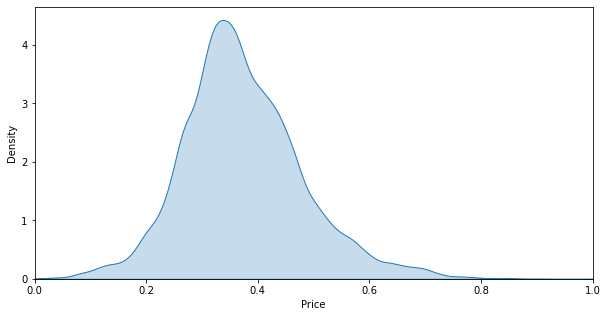

In [11]:
# Density exploring
col = f1  # df_train['f28']# .apply(lambda x: None if x == -1 else x)
x = cleaned_df['f17'] #(col - col.min())/(col.max() - col.min())
plt.figure(figsize=(10,5))
plt.xlim(0,1)
plt.xlabel('Price')
plt.ylabel('Density')
sns.kdeplot(x,shade=True)
plt.show()

df_train[['f19', 'f18']].value_counts(sort=0, normalize=True)*100

## Features

Categorical:
f9: 5 farger kan evt konvertere til tre features med 1/0 i rgb kolonner
f22: 3 farger

Numerical:
f5: 12
f8: continuous
f10: 26
f11: continuous
f12: continuous
f13: 26
f14: continuous
f15 continuous but weird distribution
f17: long-tail
f23: cont
f24 continuous but weird distribution
f1: cont, but words converted to their ordinal encoding

Both:
f0 : 2
f3: 3
f4 : 2
f6: 2
f7: 6
f18: 6, a-f men ikke noe lineært der. Nesten helt lik fordeling og targetinntrykk som f19
f19: 6, a-f men ikke noe lineært der. Nesten helt lik fordeling og targetinntrykk som f18
f20: 4,
f21: 7
f22: 3
f25: 2 TF
f26: 2 S/N

TOSS:
f27 is the same as f20. Toss one of them.


TODO:
f9

rgb

1,0,0
0,1,0
1,1,1
0,0,0
1,1,0

In [12]:
cleaned_df.iloc[:5, 10:20]

,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17
0,0.590215,yellow,0.08,0.234947,0.108895,0.500000,0.088004,0.470652,1.0,0.411984
1,0.625974,green,0.00,0.291058,0.362094,0.428571,0.334158,0.114032,NaN,0.268834
2,0.648969,white,0.28,0.484297,0.942573,0.142857,0.680349,0.717129,2.0,0.330668
3,0.085286,yellow,0.40,0.120424,0.337501,0.142857,0.526789,0.649460,4.0,NaN
4,0.702688,yellow,0.96,0.501600,0.334802,0.000000,0.192889,0.470652,1.0,0.236807


In [13]:
df_train['f9'].value_counts()

red       13429
white     11704
green      9169
yellow     7963
black      6246
Name: f9, dtype: int64

In [14]:
df_train['f22'].replace({'R': 0, 'G': 1, 'B': 2})

0        0.0
1        NaN
2        1.0
3        1.0
4        2.0
        ... 
49995    0.0
49996    0.0
49997    1.0
49998    0.0
49999    1.0
Name: f22, Length: 50000, dtype: float64

In [15]:
cleaned_df.to_csv('engineered_data.csv')

In [16]:
X_tr, X_vl = train_test_split(cleaned_df.drop(['id', 'target', 'f9'], axis=1), test_size=0.1, random_state=0)
Y_tr, Y_vl = train_test_split(cleaned_df['target'], test_size=0.1, random_state=0)

counter = Counter(cleaned_df['target'])
imbalancedness = counter[0] / counter[1]
print(f'Imbalanced by: {imbalancedness}')

Imbalanced by: 4.4019014693172


In [54]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=imbalancedness)
# clf.fit(X_tr, Y_tr)

In [56]:
y_pred = clf.predict(X_vl)
print(confusion_matrix(y_pred=y_pred, y_true=Y_vl))


NotFittedError: need to call fit or load_model beforehand

In [49]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_tr, Y_tr, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.72247


In [55]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_tr, Y_tr, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.71809


In [60]:
clf.fit(X_tr, Y_tr, verbose=True)
y_pred = clf.predict(X_vl)
print(confusion_matrix(y_pred=y_pred, y_true=Y_vl))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[3122  927]
 [ 434  517]]


In [49]:
def clean_and_feature_engineer(filepath_x:str):
    """
    Takes in the dataset, and does the feature engineering on the data. If it is a training set (containing a target
    column, it should extract this, and return it with the cleaned and feture engineered dataset.
    :param filepath_X: relative filepath to the dataset csv file
    :return: the tuple of (X, y) if a target col exists, else (X,)

    ToDo:
    - Currently it normalizes over largest recorded in whatever it sends in, meaning the normalization is different for
    train and test. Make this function based on constants or adapt to allow running both through at same time.
    - Maybe we do not need normalization.
    """

    original_df = pd.read_csv(filepath_x).copy(deep=True)
    df_x = original_df.copy(deep=True)
    df_y = None
    training_bool = 'target' in df_x
    if training_bool:
        df_y = df_x['target'].apply(lambda x: float(x) if pd.notnull(x) else x)
        df_x.drop(['target'], axis=1, inplace=True)
    df_x.drop(['id'], axis=1, inplace=True)


    # FEATURE ENGINEERING

    # f0 is left unaltered

    # f1_temp is converted to its value, but need helper function for it
    def ord_multi(x):
        '''
        Takes inn a string with two letters, takes ordinal of each and assumes base 26
        :param x: string of two letters, can be both cap an low-case
        :return: float
        '''
        if pd.isnull(x):
            return x
        num = ord(x[0])
        if x[0].islower():
            num -= 6
        num = num * 52 # 26*2

        num += ord(x[1])
        if x[1].islower():
            num -= 6
        return num

    f1_temp = original_df['f1'].apply(ord_multi)
    df_x['f1'] = (f1_temp - f1_temp.min()) / (f1_temp.max() - f1_temp.min()) # Normalized


    # f2 is converted to its corresponding number
    df_x['f2'] = original_df['f2'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)

    # f3 is kept as is

    # f4 is converted to number
    df_x['f4'] = original_df['f4'].apply(lambda x: (x=='B')*1. if pd.notnull(x) else x)

    # f5 and f6 are nums but -1 must be removed
    df_x['f5'] = original_df['f5'].apply(lambda x: None if x == -1 else x)
    df_x['f6'] = original_df['f6'].apply(lambda x: None if x == -1 else x)

    # f7 is kept as is

    # f8 is hex, convert and normalize
    f8_temp = original_df['f8'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
    df_x['f8'] = (f8_temp - f8_temp.min())/(f8_temp.max() - f8_temp.min())  # NORMALIZING

    # no idea what to do with this, drop it.
    df_x.drop(['f9'], axis=1, inplace=True)

    # convert and normalize, from earlier "# F10 sin correlasjonsmatrise med løsningen indikerer at bokstaver har nær relasjon til de i nærheten alfabetisk.
    # også i f13. Usikker om disse trenger å normaliseres."
    f10_temp = original_df['f10'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
    df_x['f10'] = (f10_temp - f10_temp.min())/(f10_temp.max() - f10_temp.min())

    # f11 seems normally distributed. Could be an idea to push onto uniform. Is fine as is, but we normalize.
    f11_temp = original_df['f11']
    df_x['f11'] = (f11_temp - f11_temp.min())/(f11_temp.max() - f11_temp.min())

    # F12 is hex, convert and normalize
    f12_temp = original_df['f12'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
    df_x['f12'] = (f12_temp - f12_temp.min())/(f12_temp.max() - f12_temp.min())  # NORMALIZING

    # f13 is alpha, convert and normalize
    f13_temp = original_df['f13'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)
    df_x['f13'] = (f13_temp - ord('a'))/(ord('0') - ord('a'))

    # F14 is hex, convert and normalize
    f14_temp = original_df['f14'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
    df_x['f14'] = (f14_temp - f14_temp.min())/(f14_temp.max() - f14_temp.min())  # NORMALIZING

    # F15 is hex, convert and normalize
    f15_temp = original_df['f15'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
    df_x['f15'] = (f15_temp - f15_temp.min())/(f15_temp.max() - f15_temp.min())  # NORMALIZING

    df_x['f16'] = original_df['f16'] - original_df['f16'].min()

    #f17: long tail distribution. Do quantile binning / log-it
    f17_temp = np.log(original_df['f17'])
    df_x['f17'] = (f17_temp - f17_temp.min())/(f17_temp.max() - f17_temp.min())

    # f18 is capital Alpha, convert.
    df_x['f18'] = original_df['f18'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)

    # f19 is decimals, upscale.
    df_x['f19'] = original_df['f19'].apply(lambda x: 10*x if pd.notnull(x) else x)

    # binary
    df_x['f20'] = original_df['f20'].apply(lambda x: int(str(int(x)), base=2) if pd.notnull(x) else x)

    #f21 is kept as is

    # f22 is color (RGB), but how to convert?
    df_x['f22'] = original_df['f22'].replace({'R': 0, 'G': 1, 'B': 2})

    # f23 is hex again, same procedure ...
    f23_temp = original_df['f23'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
    df_x['f23'] = (f23_temp - f23_temp.min())/(f23_temp.max() - f23_temp.min())  # NORMALIZING

    # f24 is kept as is

    #f25 and f26 are bools, convert
    df_x['f25'] = original_df['f25'].apply(lambda x: (x=='T')*1. if pd.notnull(x) else x)
    df_x['f26'] = original_df['f26'].apply(lambda x: (x=='S')*1. if pd.notnull(x) else x)

    # f27 is the same as f20, dropping it as it contributes nothing
    df_x.drop(['f27'], axis=1, inplace=True)

    # f28: normally distributed.
    f28_temp = original_df['f28']
    df_x['f28'] = (f28_temp - f28_temp.min())/(f28_temp.max() - f28_temp.min())

    return df_x, df_y

In [92]:
X, Y = clean_and_feature_engineer(fp_train)
test, _ = clean_and_feature_engineer(fp_test)

X_tr, X_val, y_tr, y_val = train_test_split(X, Y, test_size=0.2)

In [102]:
counter = Counter(Y)
imbalancedness = counter[0] / counter[1]
clf = xgb.XGBRegressor(objective="binary:logistic", scale_pos_weight=imbalancedness, eval_metric='auc')
clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=20)

[0]	validation_0-auc:0.68857
[1]	validation_0-auc:0.70100
[2]	validation_0-auc:0.71542
[3]	validation_0-auc:0.71796
[4]	validation_0-auc:0.72037
[5]	validation_0-auc:0.72180
[6]	validation_0-auc:0.72603
[7]	validation_0-auc:0.72775
[8]	validation_0-auc:0.72901
[9]	validation_0-auc:0.72985
[10]	validation_0-auc:0.73255
[11]	validation_0-auc:0.73176
[12]	validation_0-auc:0.73183
[13]	validation_0-auc:0.73261
[14]	validation_0-auc:0.73311
[15]	validation_0-auc:0.73447
[16]	validation_0-auc:0.73398
[17]	validation_0-auc:0.73328
[18]	validation_0-auc:0.73389
[19]	validation_0-auc:0.73395
[20]	validation_0-auc:0.73409
[21]	validation_0-auc:0.73486
[22]	validation_0-auc:0.73558
[23]	validation_0-auc:0.73597
[24]	validation_0-auc:0.73650
[25]	validation_0-auc:0.73612
[26]	validation_0-auc:0.73632
[27]	validation_0-auc:0.73630
[28]	validation_0-auc:0.73673
[29]	validation_0-auc:0.73709
[30]	validation_0-auc:0.73708
[31]	validation_0-auc:0.73702
[32]	validation_0-auc:0.73736
[33]	validation_0-au

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=4.4019014693172, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
clf.best_iteration

37

In [104]:
y_pred = clf.predict(test, ntree_limit=clf.best_ntree_limit)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [105]:
r = pd.DataFrame(y_pred)
r['id'] = r.index + 50000
r.rename({0:'target'}, axis=1, inplace=True)
r.head()
r.to_csv('Results_simple_xgboost.csv', index=False)

In [106]:
clf.best_ntree_limit

38